# Instacart Market Basket Analysis using OSEMN(Awesome) Pipeline
### Which products will an Instacart consumer purchase again?

Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to predict which previously purchased products will be in a user’s next order.

## Problem definition:  

**orders:** This table includes all orders, namely **prior, train, and test**. It has single primary key (order_id).  
**order_products_train:** This table includes training orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).  
**order_products_prior :** This table includes prior orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).  
**products:** This table includes all products. It has a single primary key (product_id)  
**aisles:** This table includes all aisles. It has a single primary key (aisle_id)  
**departments:** This table includes all departments. It has a single primary key (department_id)  

The data that Instacart opened up indicates each order in the data as **prior, train or test**. Prior orders describe the past behaviour of a user while train and test orders regard the future behaviour that we need to predict.  

As a result, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders).  

* For the train orders Instacart reveals the results (i.e., the ordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user.

The setting of the Instacart problem is described in the figure below (orders with yellow color denotes future orders of a user).

<figure>
<center>
<img src='https://i.imgur.com/S0Miw3m.png'/>
<figcaption>Image Caption</figcaption></center>
</figure>

* Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order.

* This is a **classification problem** because we need to predict whether each pair of user and product is a reorder or not. This is indicated by the value of the reordered variable, i.e. reordered=1 or reordered=0 (see figure below).

<figure>
<center>
<img src='https://i.imgur.com/SxK2gsR.png'/>
<figcaption>Image Caption</figcaption></center>
</figure>

* As a result we need to come up and calculate various predictor variables (X) that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. As a result we create a table as the following one and we train an algorithm based on predictor variables (X) and response variable (Y).

<figure>
<center>
<img src='https://i.imgur.com/Yb1CKAF.png'/>
<figcaption>Image Caption</figcaption></center>
</figure>

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
#set up some environment variables and import some libraries that we need for our code
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

import findspark
findspark.init()

import pyspark
# To use Spark and its API import the SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext

# Create Spark Context
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier

## 1. Obtain the data
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.

1.1 Import the required packages
The garbage collector (package gc), attempts to reclaim garbage, or memory occupied by objects (e.g., DataFrames) that are no longer in use by Python (ref1, ref2). This package will eliminate our risk to exceed the 16GB threshold of available RAM that Kaggle offers.

The "as" reserved word is to define an alias to the package. The alias help us to call easier a package in our code.

In [ ]:
from pyspark.sql.types import *
# Define schema for aisles
schemaaisles = StructType([StructField('aisle_id', IntegerType(), True),
                     StructField('aisle', StringType(), True)])
# Define schema for departments
schemadepartment = StructType([StructField('department_id', IntegerType(), True),
                     StructField('department', StringType(), True)])
# Define schema for ordered products
schemaordproduct = StructType([StructField('order_id', IntegerType(), True),
                     StructField('product_id', IntegerType(), True),
                     StructField('add_to_cart_order', StringType(), True),
                     StructField('reordered', StringType(), True)])
# Define schema for orders
schemaOrders = StructType([StructField('order_id', IntegerType(), True),
                     StructField('user_id', StringType(), True), 
                     StructField('eval_set', StringType(), True), 
                     StructField('order_number', StringType(), True), 
                     StructField('order_dow', StringType(), True), 
                     StructField('order_hour_of_day', StringType(), True),
                     StructField('days_since_prior_order', StringType(), True) 
                    ])
# Define schema for products
schemaproduct = StructType([StructField('product_id', IntegerType(), True),
                     StructField('product_name', StringType(), True),
                     StructField('aisle_id', StringType(), True),
                     StructField('department_id', IntegerType(), True)])

In [ ]:
#load in the files
df_aisles = sqlContext.read.csv('/content/aisles.csv',header=True, schema=schemaaisles)
df_dept = sqlContext.read.csv('/content/departments.csv',header=True, schema=schemadepartment)
df_ord_prior = sqlContext.read.csv('/content/order_products__prior.csv',header=True, schema=schemaordproduct)
df_ord_train = sqlContext.read.csv('/content/order_products__train.csv',header=True, schema=schemaordproduct)
df_orders = sqlContext.read.csv('/content/orders.csv',header=True, schema=schemaOrders)
df_products = sqlContext.read.csv('/content/products.csv',header=True, schema=schemaproduct)
df_orders.show(5)

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|               08|                  null|
| 2398795|      1|   prior|           2|        3|               07|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|               07|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows



In [ ]:
df_ord_prior.show(5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
|       2|      9327|                3|        0|
|       2|     45918|                4|        1|
|       2|     30035|                5|        0|
+--------+----------+-----------------+---------+
only showing top 5 rows



Merge the Orders with prior orders and create one DataFrame with primary key order ID

In [ ]:
# Merge the orders df with order_products_prior df by their order_id, keep only these rows with order_id that they are appear on both DFs  
opp_df = df_orders.join(df_ord_prior, on=['order_id'], how='inner')  
opp_df.show(5)  
# This df contains for all the customers (user_id):  
       #➡︎ the orders (order_id) that they have placed accompanied with:
       #➡︎ the products (product_id) that have been bought in each order

+--------+-------+--------+------------+---------+-----------------+----------------------+----------+-----------------+---------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|product_id|add_to_cart_order|reordered|
+--------+-------+--------+------------+---------+-----------------+----------------------+----------+-----------------+---------+
|     148|  41523|   prior|          27|        2|               17|                   5.0|     38650|                1|        0|
|     148|  41523|   prior|          27|        2|               17|                   5.0|     25659|                2|        0|
|     148|  41523|   prior|          27|        2|               17|                   5.0|     35951|                3|        1|
|     148|  41523|   prior|          27|        2|               17|                   5.0|     34197|                4|        1|
|     148|  41523|   prior|          27|        2|               17|               

## 2. Scrubbing / Cleaning the data


We are now ready to identify/create **predictor variables** based on the provided data. We can create various types of predictors such as:

--> User predictors describing the behavior of a user e.g. total number of orders of a user.  
--> Product predictors describing characteristics of a product e.g. total number of times a product has been purchased.  
--> User & product predictors describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.  

### 2.1 Create user predictors

2.1.1 Number of orders per customer:   
We calculate the total number of placed orders per customer. We create a user DataFrame to store the results.  

In [ ]:
import pyspark.sql.functions as F

# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
user = opp_df.groupBy('user_id').agg(F.max('order_number')).toDF('user_id','u_total_orders')
user.show(5)

+-------+--------------+
|user_id|u_total_orders|
+-------+--------------+
| 100010|             9|
| 100140|             3|
| 100227|             7|
| 100263|             9|
| 100320|             9|
+-------+--------------+
only showing top 5 rows



2.1.2 How frequent a customer has reordered products:  
This feature is a ratio which shows for each user in what extent has products that have been reordered in the past:  

<figure>
<center>
<img src='https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id)=&space;\frac{total\&space;times\&space;of\&space;reorders}{total\&space;number\&space;of\&space;purchased\&space;products\&space;from\&space;all\&space;baskets}'/>
<figcaption>Image Caption</figcaption></center>
</figure>





The nominator is a counter for all the times a user has reordered products (value on reordered=1), the denominator is a counter of all the products that have been purchased on all user's orders (reordered=0 & reordered=1).

In [ ]:
u_reorder_df = opp_df.groupBy('user_id').agg(F.round(F.mean('reordered'),2)).toDF('user_id','u_reordered_ratio')
u_reorder_df.show(5)

+-------+-----------------+
|user_id|u_reordered_ratio|
+-------+-----------------+
| 145518|              0.6|
| 154770|             0.42|
| 105758|              0.6|
| 143037|             0.79|
|  14369|             0.53|
+-------+-----------------+
only showing top 5 rows



The new feature will be merged with the user DataFrame (section 2.1.1) which keep all the features based on users. We perform a left join as we want to keep all the users that we have created on the user DataFrame.


<figure>
<center>
<img src='https://i.imgur.com/wMmC4hb.jpg' , width="220" height="120"/>
<figcaption>Image Caption</figcaption></center>
</figure>


In [ ]:
#Join total orders feature with reorder ratio feature and create one single dataframe
user_df = user.join(u_reorder_df, on='user_id', how='left').toDF('user_id','u_total_orders','u_reordered_ratio')
user_df.show(5)

+-------+--------------+-----------------+
|user_id|u_total_orders|u_reordered_ratio|
+-------+--------------+-----------------+
| 100010|             9|             0.42|
| 100140|             3|             0.13|
| 100227|             7|             0.48|
| 100263|             9|             0.82|
| 100320|             9|             0.45|
+-------+--------------+-----------------+
only showing top 5 rows



## 2.2 Create product predictors  
2.2.1 Number of purchases for each product:  
We calculate the total number of purchases for each product (from all customers). We create a prd DataFrame to store the results.  

In [ ]:
# Create distinct groups for each product, count the orders, save the result for each product to a new DataFrame  
prd_df = opp_df.groupBy('product_id').agg(F.count('order_id')).toDF('product_id','p_total_purchases')
prd_df.show(5)

+----------+-----------------+
|product_id|p_total_purchases|
+----------+-----------------+
|     41890|             1949|
|      8592|              990|
|     29228|              547|
|     40386|             2708|
|     42834|             1800|
+----------+-----------------+
only showing top 5 rows



2.2.2 What is the probability for a product to be reordered:  
In this section we want to find the products which have the highest probability of being reordered. Towards this end it is necessary to define the probability as below:


<figure>
<center>
<img src='https://latex.codecogs.com/gif.latex?\dpi{150}&space;\large&space;probability\&space;reordered\&space;(product\_id)=&space;\frac{number\&space;of\&space;reorders}{total\&space;number\&space;of\&space;orders\&space;}'/>
<figcaption>Image Caption</figcaption></center>
</figure>



2.2.2.1 Group products, calculate the mean of reorders  
To calculate the reorder probability we will use the aggregation function mean() to the reordered column. In the reorder data frame, the reordered column indicates that a product has been reordered when the value is 1.

The .mean() calculates how many times a product has been reordered, divided by how many times has been ordered in total.

In [ ]:
# Calculate the ratio for each product. The aggregation function is limited to column 'reordered' and it calculates the mean value of each group.
p_reorder_df = opp_df.groupBy('product_id').agg(F.round(F.mean('reordered'),2)).toDF('product_id','p_reorder_ratio')
p_reorder_df.show(5)

+----------+---------------+
|product_id|p_reorder_ratio|
+----------+---------------+
|     41890|            0.7|
|      8592|           0.63|
|     29228|           0.24|
|     40386|            0.6|
|     42834|           0.51|
+----------+---------------+
only showing top 5 rows



2.2.2.2 Merge the new feature on prd DataFrame
The new feature will be merged with the prd DataFrame (section 2.2.1) which keep all the features based on products. We perform a left join as we want to keep all the products that we have created on the prd DataFrame

<figure>
<center>
<img src='https://i.imgur.com/dOVWPKb.jpg' , width="260" height="150"/>
<figcaption>Image Caption</figcaption></center>
</figure>



In [ ]:
#Join total orders feature with reorder ratio feature and create one single dataframe
product_df = prd_df.join(p_reorder_df, on='product_id', how='left').toDF('product_id','p_total_purchases','p_reorder_ratio')
product_df.show(5)

+----------+-----------------+---------------+
|product_id|p_total_purchases|p_reorder_ratio|
+----------+-----------------+---------------+
|       148|             4903|           0.57|
|       463|               32|           0.13|
|       471|              138|           0.57|
|       496|               37|           0.38|
|       833|               12|           0.08|
+----------+-----------------+---------------+
only showing top 5 rows



## 2.3 Create user-product predictors
**2.3.1 How many times a user bought a product:**  
We create different groups that contain all the rows for each combination of user and product. With the aggregation function .count( ) we get how many times each user bought a product. We save the results on new uxp DataFrame.

In [ ]:
# Create distinct groups for each combination of user and product, count orders, save the result for each user X product to a new DataFrame 
uxp = opp_df.groupBy(['user_id', 'product_id']).agg(F.count('order_id')).toDF('user_id', 'product_id','uxp_total_bought')
uxp.show(5)

+-------+----------+----------------+
|user_id|product_id|uxp_total_bought|
+-------+----------+----------------+
| 132282|     26298|              10|
|   7293|     47209|              10|
|  86208|     31066|               1|
|  51994|     33373|               1|
|  34461|     24852|              17|
+-------+----------+----------------+
only showing top 5 rows



**2.3.2 How frequently a customer bought a product after its first purchase:**  
Which is actually the following ratio for each combination of customer and product:  
<figure>
<center>
<img src='https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id\&space;,&space;product\_id)&space;=&space;\frac{times\&space;a\&space;user\&space;bought\&space;a\&space;product}{number&space;\&space;of\&space;orders\&space;placed\&space;since\&space;first\&space;purchase}'/>
<figcaption>Image Caption</figcaption></center>
</figure>

Before we show how we can create the above ratio we declare the following variables:

* How many times a customer bought a product? ('Times_Bought_N')
* For each product get the total orders placed since its first order ('Order_Range_D')

<figure>
<center>
<img src='https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id\&space;,&space;product\_id)&space;=&space;\frac{Times\_Bought\_N}{Order\_Range\_D}'/>
<figcaption>Image Caption</figcaption></center>
</figure>

Where Order_Range_D is created throught two supportive variables:

* The total number of orders for each customer ('total_orders')
* The order number where the customer bought a product for first time ('first_order_number')

<figure>
<center>
<img src='https://latex.codecogs.com/gif.latex?%5Cdpi%7B120%7D%20%5C%20%5C%20%5C%20%5C%20%5C%20Order%5C_Range%5C_D%28user%5C_id%2C%20product%5C_id%29%20%3D%20%5Cnewline%20%3D%5C%20total%5C_orders%28user%5C_id%29%20-%20first%5C_order%5C_number%28user%5C_id%2C%20product%5C_id%29%20+%201'/>
<figcaption>Image Caption</figcaption></center>
</figure>

In the next blocks we show how we create:

1. The numerator 'Times_Bought_N'
2. The supportive variables 'total_orders' & 'first_order_number'
3. The denumerator 'Order_Range_D' with the use of the supportive variables
4. Our final ratio 'uxp_order_ratio'


**2.3.2.1 Calculating the numerator - How many times a customer bought a product? ('Times_Bought_N')**

To answer this question we simply .groupby( ) user_id & product_id and we count the instances of order_id for each group.

In [ ]:
# We calculated already this in Step - 2.3.1 (How many times a user bought a product:), just rename the coulmn
times_bought_df = uxp.toDF('user_id', 'product_id','Times_Bought_N')
times_bought_df.head(5)

[Row(user_id='132282', product_id=26298, Times_Bought_N=10),
 Row(user_id='7293', product_id=47209, Times_Bought_N=10),
 Row(user_id='86208', product_id=31066, Times_Bought_N=1),
 Row(user_id='51994', product_id=33373, Times_Bought_N=1),
 Row(user_id='34461', product_id=24852, Times_Bought_N=17)]

**2.3.2.2 Calculating the denumerator**

To calculate the denumerator, we have first to calculate the total orders of each user & first order number for each user and every product purchase

**2.3.2.2.a The total number of orders for each customer ('total_orders')** 📚📝  
Here we .groupby( ) only by the user_id, we keep the column order_number and we get its highest value with the aggregation function .mean()

In [ ]:
# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
# We caculated this in step - 2.1.1 Number of orders per customer:
#total_orders_df = user.toDF('user_id', 'u_total_orders')
total_orders_df = user
total_orders_df.show(5)

+-------+--------------+
|user_id|u_total_orders|
+-------+--------------+
| 100010|             9|
| 100140|             3|
| 100227|             7|
| 100263|             9|
| 100320|             9|
+-------+--------------+
only showing top 5 rows



**2.3.2.2.b The order number where the customer bought a product for first time ('first_order_number')**
Where for first_order_number we .groupby( ) by both user_id & product_id. As we want to get the order when a product has been purchases for first time, we select the order_number column and we retrieve with .min( ) aggregation function, the earliest order.

In [ ]:
# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
first_order_df = opp_df.groupBy(['user_id','product_id']).agg(F.min('order_number')).toDF('user_id','product_id','first_order_number')
first_order_df.show(5)

+-------+----------+------------------+
|user_id|product_id|first_order_number|
+-------+----------+------------------+
|  10000|     41570|                 6|
| 100001|     22474|                66|
| 100008|     25146|                28|
| 100008|     26885|                10|
| 100010|      1447|                 1|
+-------+----------+------------------+
only showing top 5 rows



We merge the first order number with the total_orders DataFrame. As total_orders refers to all users, where first_order_no refers to unique combinations of user & product, we perform a right join:

<figure>
<center>
<img src='https://i.imgur.com/bhln0tn.jpg', width="260" height="150"/>
<figcaption>Image Caption</figcaption></center>
</figure>

In [ ]:
span_df = total_orders_df.join(first_order_df, on=['user_id'], how='right')  
span_df.head()

Row(user_id='100010', u_total_orders='9', product_id=1447, first_order_number='1')

**2.3.2.2.c For each product get the total orders placed since its first order ('Order_Range_D')**
The denominator now can be created with simple operations between the columns of results DataFrame:

In [ ]:
# The +1 includes in the difference the first order where the product has been purchased
span_df = span_df.withColumn('Order_Range_D', span_df.u_total_orders - span_df.first_order_number + 1)
span_df.head()

Row(user_id='100010', u_total_orders='9', product_id=1447, first_order_number='1', Order_Range_D=9.0)

**2.3.2.3 Create the final ratio "uxp_reorder_ratio"**

2.3.2.3.a Merge the DataFrames of numerator & denumerator
We select to merge times DataFrame which contains the numerator & span which contains the denumerator of our desired ratio. As both variables derived from the combination of users & products, any type of join will keep all the combinations.

<figure>
<center>
<img src='https://i.imgur.com/h7m1bFh.jpg', width="260" height="150"/>
<figcaption>Image Caption</figcaption></center>
</figure>

In [ ]:
uxp_ratio = times_bought_df.join(span_df, on=['user_id', 'product_id'], how='left')
uxp_ratio.show()

Row(user_id='10000', product_id=41570, Times_Bought_N=1, u_total_orders='9', first_order_number='6', Order_Range_D=4.0)

2.3.2.3.b Perform the final division
Here we divide the Times_Bought_N by the Order_Range_D for each user and product.

In [ ]:
uxp_ratio = uxp_ratio.withColumn('uxp_reorder_ratio', uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D) ##
uxp_ratio.show()

Row(user_id='10000', product_id=41570, Times_Bought_N=1, u_total_orders='9', first_order_number='6', Order_Range_D=4.0, uxp_reorder_ratio=0.25)

**2.3.2.3.c Keep the final feature**
We select to keep only the 'user_id', 'product_id' and the final feature 'uxp_reorder_ratio'

In [ ]:
uxp_ratio = uxp_ratio.drop('Times_Bought_N', 'u_total_orders', 'first_order_number', 'Order_Range_D')
uxp_ratio.show()

Row(user_id='10000', product_id=41570, uxp_reorder_ratio=0.25)

**2.3.2.4 Merge the final feature with uxp DataFrame**
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame.

<figure>
<center>
<img src='https://i.imgur.com/hPJXBuB.jpg', width="260" height="150"/>
<figcaption>Image Caption</figcaption></center>
</figure>

In [ ]:
uxp_df = uxp.join(uxp_ratio, on=['user_id', 'product_id'], how='left')
uxp_df.show()

Row(user_id='10000', product_id=41570, uxp_total_bought=1, uxp_reorder_ratio=0.25)

In [ ]:
del uxp_ratio

## 2.4 Merge all features  
We now merge the RDDs/DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the uxp RDD/DataFrame and we will add the user and prd DataFrames. We do so because we want our final DataFrame (which will be called data) to have the following structure:


<figure>
<center>
<img src='https://i.imgur.com/mI5BbFE.jpg', width="800" height="400"/>
<figcaption>Image Caption</figcaption></center>
</figure>

2.4.1 Merge uxp with user DataFrame
Here we select to perform a left join of uxp with user DataFrame based on matching key "user_id"


<figure>
<center>
<img src='https://i.imgur.com/WlI84Ud.jpg', width="260" height="150"/>
<figcaption>Image Caption</figcaption></center>
</figure>

Left join, ensures that the new DataFrame will have:

* all the observations of the uxp (combination of user and products) DataFrame
* all the matching observations of user DataFrame with uxp based on matching key "user_id"
The new DataFrame as we have already mentioned, will be called data.

In [ ]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp_df.join(user_df, on='user_id', how='left')
data.show()

Row(user_id='100010', product_id=1447, uxp_total_bought=4, uxp_reorder_ratio=0.4444444444444444, u_total_orders='9', u_reordered_ratio=0.42)

**2.4.1 Merge data with prd DataFrame**  
In this step we continue with our new DataFrame data and we perform a left join with prd DataFrame. The matching key here is the "product_id".

<figure>
<center>
<img src='https://i.imgur.com/Iak6nIz.jpg', width="260" height="150"/>
<figcaption>Image Caption</figcaption></center>
</figure>

Left join, ensures that the new DataFrame will have:

* all the observations of the data (features of userXproducts and users) DataFrame
* all the matching observations of prd DataFrame with data based on matching key "product_id"



In [ ]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.join(prd_df, on='product_id', how='left')
data.show(5)

[Row(product_id=148, user_id='100227', uxp_total_bought=1, uxp_reorder_ratio=0.25, u_total_orders='7', u_reordered_ratio=0.48, p_total_purchases=4903),
 Row(product_id=148, user_id='143293', uxp_total_bought=1, uxp_reorder_ratio=0.3333333333333333, u_total_orders='9', u_reordered_ratio=0.55, p_total_purchases=4903),
 Row(product_id=148, user_id='143443', uxp_total_bought=1, uxp_reorder_ratio=-0.037037037037037035, u_total_orders='9', u_reordered_ratio=0.67, p_total_purchases=4903),
 Row(product_id=148, user_id='144481', uxp_total_bought=2, uxp_reorder_ratio=0.5, u_total_orders='9', u_reordered_ratio=0.63, p_total_purchases=4903),
 Row(product_id=148, user_id='145015', uxp_total_bought=1, uxp_reorder_ratio=0.16666666666666666, u_total_orders='9', u_reordered_ratio=0.31, p_total_purchases=4903)]

In [ ]:
#Delete temporary user DataFrames
#del u_reorder_df
#del user_df
#delete temporary product dataframe
#del p_reorder_df
#del prd_df
#delete temporary user+product DataFrames
#del times_bought_df
#del total_orders_df
#del first_order_df
#del span_df

# 3. Create train and test DataFrames

**3.1 Include information about the last order of each user**  
The data DataFrame that we have created on the previous chapter (2.4) should include two more columns which define the type of user (train or test) and the order_id of the future order. This information can be found on the initial orders DataFrame which was provided by Instacart:

<figure>
<center>
<img src='https://i.imgur.com/PDu2vfR.jpg', width="800" height="400"/>
<figcaption>Image Caption</figcaption></center>
</figure>

Towards this end:  

1. We select the orders DataFrame to keep only the future orders (labeled as "train" & "test).  
2. Keep only the columns of our desire ['eval_set', 'order_id'] **AND** 'user_id' as is the matching key with our data DataFrame  
3. Merge data DataFrame with the information for the future order of each customer using as matching key the 'user_id'  

To filter and select the columns of our desire on orders (the 2 first steps) there are numerous approaches:

In [ ]:
# In two steps keep only the future orders from all customers: train & test 
orders_future = df_orders.filter(F.col('eval_set').isin(['train','test']))
orders_future = orders_future.select('user_id', 'eval_set', 'order_id')
orders_future.take(5)

[Row(user_id='1', eval_set='train', order_id=1187899),
 Row(user_id='2', eval_set='train', order_id=1492625),
 Row(user_id='3', eval_set='test', order_id=2774568),
 Row(user_id='4', eval_set='test', order_id=329954),
 Row(user_id='5', eval_set='train', order_id=2196797)]

To fulfill step 3, we merge on data DataFrame the information for the last order of each customer. The matching key here is the user_id and we select a left join as we want to keep all the observations from data DataFrame.


<figure>
<center>
<img src='https://i.imgur.com/m3pNVDW.jpg', width="260" height="150"/>
<figcaption>Image Caption</figcaption></center>
</figure>

In [ ]:
# bring the info of the future orders to data DF
data = data.join(orders_future, on='user_id', how='left')
data.take(10)

+-------+----------+----------------+------------------+--------------+-----------------+-----------------+--------+--------+
|user_id|product_id|uxp_total_bought| uxp_reorder_ratio|u_total_orders|u_reordered_ratio|p_total_purchases|eval_set|order_id|
+-------+----------+----------------+------------------+--------------+-----------------+-----------------+--------+--------+
| 100010|     25283|               1|               0.5|             9|             0.42|              744|    test|  339079|
| 100010|      4391|               1|               1.0|             9|             0.42|              589|    test|  339079|
| 100010|      3042|               2|              0.25|             9|             0.42|             1287|    test|  339079|
| 100010|      7222|               1|             0.125|             9|             0.42|              290|    test|  339079|
| 100010|     34735|               1|0.1111111111111111|             9|             0.42|              498|    test|  

**3.2 Prepare the train DataFrame**  
In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

Towards this end:

1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors. 

So now we filter the data DataFrame so to keep only the train users:



In [ ]:
#Keep only the customers who we know what they bought in their future order
data_train = data.filter(data.eval_set == 'train')
data_train.take(5)

+-------+----------+----------------+------------------+--------------+-----------------+-----------------+--------+--------+
|user_id|product_id|uxp_total_bought| uxp_reorder_ratio|u_total_orders|u_reordered_ratio|p_total_purchases|eval_set|order_id|
+-------+----------+----------------+------------------+--------------+-----------------+-----------------+--------+--------+
| 100140|     22227|               1|0.3333333333333333|             3|             0.13|             4685|   train| 1881518|
| 100140|     27156|               1|0.3333333333333333|             3|             0.13|            38001|   train| 1881518|
| 100140|     49175|               1|0.3333333333333333|             3|             0.13|            10829|   train| 1881518|
| 100140|     18027|               1|               1.0|             3|             0.13|            17789|   train| 1881518|
| 100140|       432|               2|0.6666666666666666|             3|             0.13|            30935|   train| 1

For these customers we get from order_products_train the products that they have bought. The matching keys are here two: the "product_id" & "order_id". A left join keeps all the observations from data_train DataFrame.

<figure>
<center>
<img src='https://i.imgur.com/kndys9d.jpg', width="300" height="170"/>
<figcaption>Image Caption</figcaption></center>
</figure>

In [ ]:
#Get from order_products_train all the products that the train users bought in their future order
data_train = data_train.join(df_ord_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.take(15)

+----------+--------+-------+----------------+--------------------+--------------+-----------------+-----------------+--------+---------+
|product_id|order_id|user_id|uxp_total_bought|   uxp_reorder_ratio|u_total_orders|u_reordered_ratio|p_total_purchases|eval_set|reordered|
+----------+--------+-------+----------------+--------------------+--------------+-----------------+-----------------+--------+---------+
|         1| 3032229|  31500|               1|  0.3333333333333333|             9|             0.75|             1852|   train|     null|
|         3|  228620| 188068|               1|               0.125|             9|             0.55|              277|   train|     null|
|         7| 2435279|  50414|               1|                -0.5|             9|             0.56|               30|   train|     null|
|         9| 1056575|  65966|               1|  0.1111111111111111|             9|             0.54|              156|   train|     null|
|         9| 1922156| 151017|     

On the last columm (reordered) you can find out our response (y). There are combinations of User X Product which they were reordered (1) on last order where other were not (NaN value).  

Now we manipulate the data_train DataFrame, to bring it into a structure for Machine Learning (X1,X2,....,Xn, y):  

* Fill NaN values with value zero (regards reordered rows without value = 1)

In [ ]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train  = data_train.fillna({'reordered':'0'}) 
data_train.take(5)

[Row(product_id=1, order_id=3032229, user_id='31500', uxp_total_bought=1, uxp_reorder_ratio=0.3333333333333333, u_total_orders='9', u_reordered_ratio=0.75, p_total_purchases=1852, eval_set='train', reordered='0'),
 Row(product_id=3, order_id=228620, user_id='188068', uxp_total_bought=1, uxp_reorder_ratio=0.125, u_total_orders='9', u_reordered_ratio=0.55, p_total_purchases=277, eval_set='train', reordered='0'),
 Row(product_id=7, order_id=2435279, user_id='50414', uxp_total_bought=1, uxp_reorder_ratio=-0.5, u_total_orders='9', u_reordered_ratio=0.56, p_total_purchases=30, eval_set='train', reordered='0'),
 Row(product_id=9, order_id=1056575, user_id='65966', uxp_total_bought=1, uxp_reorder_ratio=0.1111111111111111, u_total_orders='9', u_reordered_ratio=0.54, p_total_purchases=156, eval_set='train', reordered='0'),
 Row(product_id=9, order_id=1922156, user_id='151017', uxp_total_bought=3, uxp_reorder_ratio=0.3333333333333333, u_total_orders='9', u_reordered_ratio=0.65, p_total_purchases=

* Set as index the column(s) that describe uniquely each row (in our case "user_id" & "product_id")

In [ ]:
#We set user_id and product_id as the index of the DF
#data_train = data_train.set_index(['user_id', 'product_id'])
#data_train.head(15)

* Remove columns which are not predictors (in our case: 'eval_set','order_id')

In [ ]:
#We remove all non-predictor variables
data_train = data_train.drop('eval_set','order_id')
data_train.take(5)

+----------+-------+----------------+------------------+--------------+-----------------+-----------------+---------+
|product_id|user_id|uxp_total_bought| uxp_reorder_ratio|u_total_orders|u_reordered_ratio|p_total_purchases|reordered|
+----------+-------+----------------+------------------+--------------+-----------------+-----------------+---------+
|         1|  31500|               1|0.3333333333333333|             9|             0.75|             1852|        0|
|         3| 188068|               1|             0.125|             9|             0.55|              277|        0|
|         7|  50414|               1|              -0.5|             9|             0.56|               30|        0|
|         9|  65966|               1|0.1111111111111111|             9|             0.54|              156|        0|
|         9| 151017|               3|0.3333333333333333|             9|             0.65|              156|        0|
+----------+-------+----------------+------------------+

**3.3 Prepare the test DataFrame**  
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column (as it is the label that we want to predict).

To create it, we:
* Keep only the customers who are labelled as test

In [ ]:
#Keep only the future orders from customers who are labelled as test
data_test = data.filter(data.eval_set == 'test') 
data_test.take(5)

+-------+----------+----------------+------------------+--------------+-----------------+-----------------+--------+--------+
|user_id|product_id|uxp_total_bought| uxp_reorder_ratio|u_total_orders|u_reordered_ratio|p_total_purchases|eval_set|order_id|
+-------+----------+----------------+------------------+--------------+-----------------+-----------------+--------+--------+
| 100010|     25283|               1|               0.5|             9|             0.42|              744|    test|  339079|
| 100010|      4391|               1|               1.0|             9|             0.42|              589|    test|  339079|
| 100010|      3042|               2|              0.25|             9|             0.42|             1287|    test|  339079|
| 100010|      7222|               1|             0.125|             9|             0.42|              290|    test|  339079|
| 100010|     34735|               1|0.1111111111111111|             9|             0.42|              498|    test|  

* Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")

In [ ]:
#We set user_id and product_id as the index of the DF
#data_test = data_test.set_index(['user_id', 'product_id'])
#data_test.head()

* Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [ ]:
#We remove all non-predictor variables
data_test = data_test.drop('eval_set','order_id')
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.take(5)

[Row(user_id='100010', product_id=25283, uxp_total_bought=1, uxp_reorder_ratio=0.5, u_total_orders='9', u_reordered_ratio=0.42, p_total_purchases=744),
 Row(user_id='100010', product_id=4391, uxp_total_bought=1, uxp_reorder_ratio=1.0, u_total_orders='9', u_reordered_ratio=0.42, p_total_purchases=589),
 Row(user_id='100010', product_id=3042, uxp_total_bought=2, uxp_reorder_ratio=0.25, u_total_orders='9', u_reordered_ratio=0.42, p_total_purchases=1287),
 Row(user_id='100010', product_id=7222, uxp_total_bought=1, uxp_reorder_ratio=0.125, u_total_orders='9', u_reordered_ratio=0.42, p_total_purchases=290),
 Row(user_id='100010', product_id=34735, uxp_total_bought=1, uxp_reorder_ratio=0.1111111111111111, u_total_orders='9', u_reordered_ratio=0.42, p_total_purchases=498)]

In [ ]:
type(data_test)

pyspark.sql.dataframe.DataFrame

## 4.  Exploring / Visualizing our data 
This will allow us to find patterns and trends.  




In [ ]:
# join prd_df with df_product to fetch the name of each product and select only necessary columns
prd_top20 = prd_df.join(df_products,on=['product_id'], how='inner') #generates Dataframe
prd_top20.show(5)

+----------+-----------------+--------------------+--------+-------------+
|product_id|p_total_purchases|        product_name|aisle_id|department_id|
+----------+-----------------+--------------------+--------+-------------+
|     41890|             1949|Organic Mesa Sunr...|     121|           14|
|      8592|              990|Kale, Apple, Ging...|      31|            7|
|     29228|              547|Original Traditio...|      72|           13|
|     40386|             2708|Major Dickason's ...|      26|            7|
|     42834|             1800|Organic Mini Peel...|     123|            4|
+----------+-----------------+--------------------+--------+-------------+
only showing top 5 rows



In [ ]:
# join df_product with Department ID to fetch Department Name
prd_top20 = prd_top20.join(df_dept,on=['department_id'], how='inner') #generates Dataframe
prd_top20.show(5)

+-------------+----------+-----------------+--------------------+--------+----------+
|department_id|product_id|p_total_purchases|        product_name|aisle_id|department|
+-------------+----------+-----------------+--------------------+--------+----------+
|           14|     41890|             1949|Organic Mesa Sunr...|     121| breakfast|
|            7|      8592|              990|Kale, Apple, Ging...|      31| beverages|
|           13|     29228|              547|Original Traditio...|      72|    pantry|
|            7|     40386|             2708|Major Dickason's ...|      26| beverages|
|            4|     42834|             1800|Organic Mini Peel...|     123|   produce|
+-------------+----------+-----------------+--------------------+--------+----------+
only showing top 5 rows



In [ ]:
# join prd_df with df_aisles to fetch the name of each product and select only necessary columns
prd_top20 = prd_top20.join(df_aisles,on=['aisle_id'], how='inner') #generates Dataframe
prd_top20.show(5)

+--------+-------------+----------+-----------------+--------------------+----------+--------------------+
|aisle_id|department_id|product_id|p_total_purchases|        product_name|department|               aisle|
+--------+-------------+----------+-----------------+--------------------+----------+--------------------+
|     121|           14|     41890|             1949|Organic Mesa Sunr...| breakfast|              cereal|
|      31|            7|      8592|              990|Kale, Apple, Ging...| beverages|        refrigerated|
|      72|           13|     29228|              547|Original Traditio...|    pantry|          condiments|
|      26|            7|     40386|             2708|Major Dickason's ...| beverages|              coffee|
|     123|            4|     42834|             1800|Organic Mini Peel...|   produce|packaged vegetabl...|
+--------+-------------+----------+-----------------+--------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
# Order By 'Total number of Purchases' and convert it to Pandas Dataframe
prd_top20_pd = prd_top20.orderBy(col('p_total_purchases'), ascending=False).toPandas()
prd_top20_pd.head(20)

,aisle_id,department_id,product_id,p_total_purchases,product_name,department,aisle
0,24,4,24852,472565,Banana,produce,fresh fruits
1,24,4,13176,379450,Bag of Organic Bananas,produce,fresh fruits
2,24,4,21137,264683,Organic Strawberries,produce,fresh fruits
3,123,4,21903,241921,Organic Baby Spinach,produce,packaged vegetables fruits
4,24,4,47209,213584,Organic Hass Avocado,produce,fresh fruits
5,24,4,47766,176815,Organic Avocado,produce,fresh fruits
6,24,4,47626,152657,Large Lemon,produce,fresh fruits
7,24,4,16797,142951,Strawberries,produce,fresh fruits
8,24,4,26209,140627,Limes,produce,fresh fruits
9,84,16,27845,137905,Organic Whole Milk,dairy eggs,milk


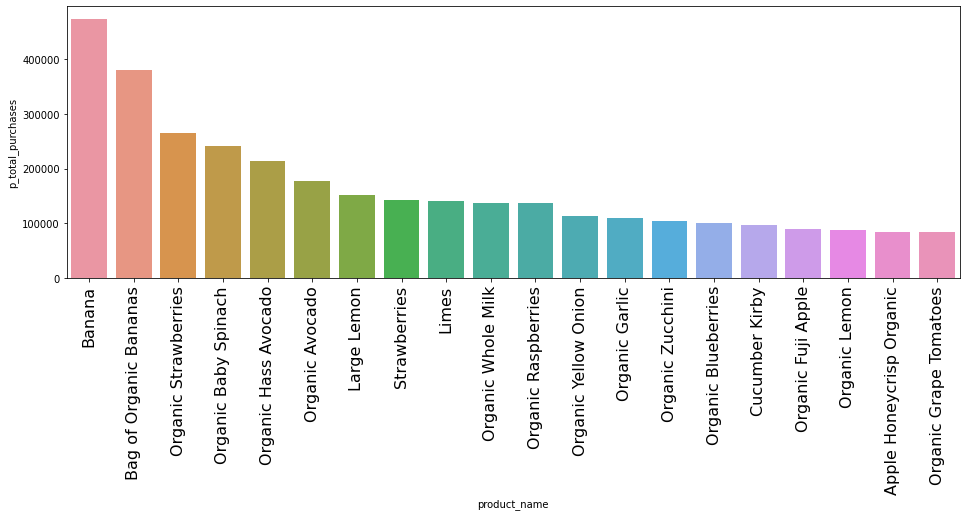

In [ ]:
#plot top 20 purchased products 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col


plt.figure(figsize=(16,5))
ax = sns.barplot(data = prd_top20_pd.sort_values(by='p_total_purchases', ascending=False)[:20], x= "product_name", y = "p_total_purchases")
plt.xticks(rotation='vertical',fontsize=16)
plt.show()

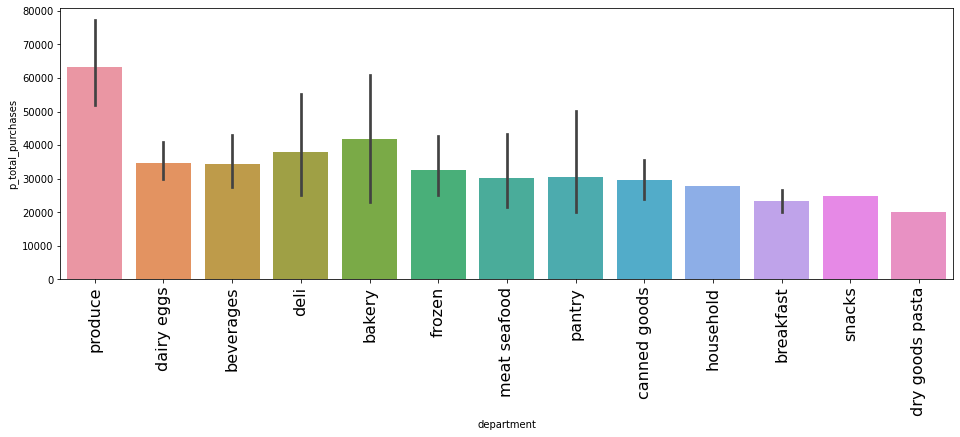

In [ ]:
#Show Top Departments that most products are Purchased from
plt.figure(figsize=(16,5))
#plt.bar
ax = sns.barplot(data = prd_top20_pd.sort_values(by='p_total_purchases', ascending=False)[:200], x= "department", y = "p_total_purchases")
plt.xticks(rotation='vertical',fontsize=16)
plt.show()

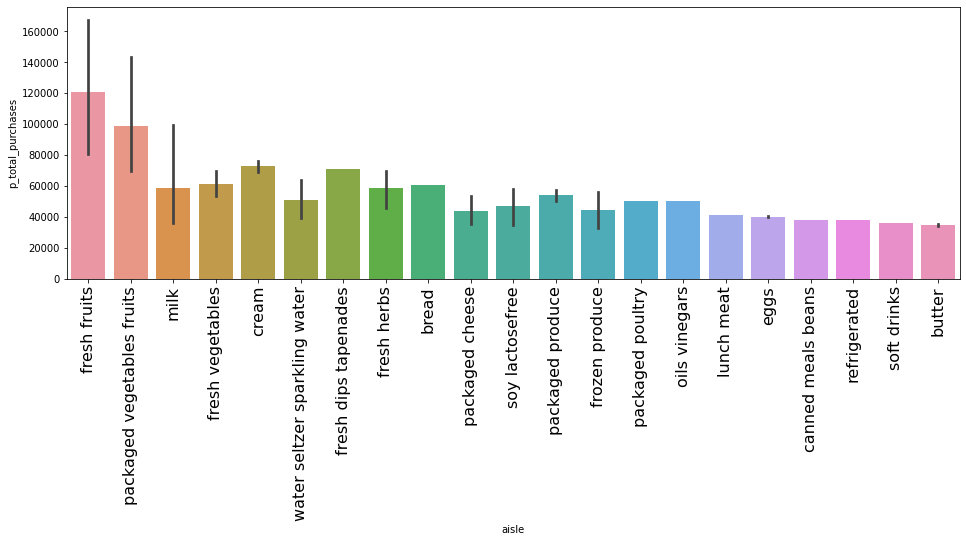

In [ ]:
#Show Top aisles that most products are Purchased from
plt.figure(figsize=(16,5))
#plt.bar
ax = sns.barplot(data = prd_top20_pd[:100], x= "aisle", y = "p_total_purchases")
plt.xticks(rotation='vertical',fontsize=16)
plt.show()

# 5. Modeling the data (Prediction Model)  

## 5.1 using Scikit-learn

To create the predictive model we:

1 - We create a DataFrame with all the predictors, named X_train and a Series with the response, named y_train

2 - We initiate a Random Forest Classifier of scikit-learn package. On RandomForestClassifier( ) you will notice different arguments:

n_estimators: defines the total number of different decision trees that will be made (can be tuned to provide better F1 score)
n_jobs: defines the total number of CPU processors that will be used to train the model. Value -1 means that all processors will be used (there is not need to be tuned)
random_state: a seed number so can reproduce the same models with our algorithm. Different seed numbers yield to slightly different models (there is not need to be tuned)

3 - Finally we train our model with the X_train and y_train data

In [ ]:
# TRAIN 80% - VALIDATE 20% 

##########################
##IMPORT REQUIRED PACKAGES
##########################
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split #validate algorithm
from sklearn.metrics import f1_score, classification_report, confusion_matrix

##############################################################
## SPLIT DF TO: 80% for training and 20% as validation (axis=0) 
## & THEN TO to X_train, X_val, y_train, y_val (axis=1)
##############################################################

X_df = data_train.drop('reordered')#.toPandas()
Y_df = data_train.select('reordered')#.toPandas()
X_df.head(5)

Py4JJavaError: ignored

In [ ]:
Y_df.head(5)

+---------+
|reordered|
+---------+
|        0|
|        0|
|        0|
|        0|
|        0|
+---------+
only showing top 5 rows



In [ ]:
from sklearn.model_selection import train_test_split  # for splitting the data into train and test sets

from sklearn.metrics import accuracy_score  # for calculating accuracy
from sklearn.metrics import precision_recall_fscore_support  # for calculating precision, recall, and F1-score
X_train, X_val, Y_train, Y_val = train_test_split(X_df, Y_df, test_size=0.2, random_state=42)

##########################
## INITIATE AND TRAIN MODEL
##########################
rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1 ,random_state=42)
model = rfc.fit(X_train, Y_train) #

Py4JJavaError: ignored

In [ ]:

#####################################
## SCORE MODEL ON VALIDATION SET
#####################################
### Predict on validation set with fixed threshold

y_val_pred = (model.predict_proba(X_val)[:,1] >= 0.30).astype(int)

### Get scores on validation set
print("RESULTS ON VALIDATION SET\n====================")
print("F1 Score: ",f1_score(y_val, y_val_pred, average='binary'), "\n====================")
print("Classification Report\n ", classification_report(y_val, y_val_pred), "\n====================")
print("Confusion Matrix\n ", confusion_matrix(y_val, y_val_pred))

### Remove validate algorithm objects
del [X_val, y_val]

In [ ]:
############################
# FEATURE IMPORTANCE - AS DF
############################
feature_importances_df = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances_df)

##################################
# FEATURE IMPORTANCE - GRAPHICAL
##################################
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
feat_importances.plot(kind='barh')

############################
# DELETE TEMPORARY OBJECTS #
############################
del [X_train, y_train]
gc.collect()

## 5.1 using Spark ML Lib


# 6. Interpreting the data

References:  
https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html
https://www.kaggle.com/uomislab/instacart-rfc-notebook  
https://spark.apache.org/docs/latest/mllib-ensembles.html  
https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc